## Table of Contents
<ul>
<li><a href="#data_loading">data_loading</a></li>
<li><a href="#text_encoding">text_encoding</a></li>
<li><a href="#text_cleaning">text_cleaning</a></li> 
        - remove numbers<br>
        -  remove stop words<br>
        - remove english word<br>
        - remove sepcail chars<br>
<li><a href="#data_exploration">data_exploration</a></li>
<li><a href="#bag_of_words">bag_of_words</a></li>
        - svm model<br>
        - bag_of_words_prediction_function<br>
<li><a href="#word_vectors">word_vectors</a></li>
        - model_loading<br>
        - spacy<br>
        - preprocessing<br>
        - svm<br>
        - aravec_prediction_function<br>
<li><a href="#deep_learning">deep_learning</a></li>
        - get embeddings matrix<br>
        - preprocessing<br>
        - LSTM model<br>
        - LSTM_prediction_function<br>
<li><a href="#CaMel_BERT">CaMel_BERT</a></li>
        - model_loading<br>
        - data_tokanization<br>
        - data_preperation<br>
        - fine_tune_model<br>
        - model_training<br>
        - test_preperation_function<br>
        - CaMel_prediction_function<br>
<li><a href="#AraBert">AraBert</a></li>
        - model_loading<br>
        - data_tokanization<br>
        - data_preperation<br>
        - fine_tune_model<br>
        - model_training<br>
        - test_preperation_function<br>
        - AraBert_prediction_function<br>
<li><a href="#BERT_Multilingual">BERT_Multilingual</a></li>
        - model_loading<br>
        - data_tokanization<br>
        - data_preperation<br>
        - fine_tune_model<br>
        - model_training<br>
        - test_preperation_function<br>
        - AraBert_prediction_function<br>
<li><a href="#comparison">comparison</a></li>
- Number of Epochs <br>
- Run Time <br>
- Train Acc <br>
</ul>
                

In [45]:
import matplotlib.pyplot as plt 
import numpy as np
import os 
import pandas as pd 
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from keras.preprocessing import sequence, text
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, GlobalMaxPool1D , TextVectorization
import spacy
import gensim
import nltk
from nltk import ngrams
from nltk import word_tokenize # break a sentence into a words 
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter #counting of words in the texts
import operator
import datetime as dt
import warnings
import string
import re

from sklearn import svm

warnings.filterwarnings('ignore')

In [4]:
directory = "D:/Bi electric scolership/NLP/data_cleaned"

In [5]:
labels = os.listdir(directory) 

In [6]:
(labels)

['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']

### data_loading

In [7]:
#load data
train_data =  tf.keras.preprocessing.text_dataset_from_directory(
    directory = directory,
    labels="inferred",
    label_mode="int",
    class_names=labels,
    max_length=None,
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="training",
    follow_links=False,
)
val_data = tf.keras.preprocessing.text_dataset_from_directory(
    directory = directory,
    labels="inferred",
    label_mode="int",
    class_names=labels,
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="validation",
    follow_links=False,
)

Found 45500 files belonging to 7 classes.
Using 31850 files for training.
Found 45500 files belonging to 7 classes.
Using 13650 files for validation.


In [8]:
for text , label in train_data:
    print(text[0].numpy()[0:30])
    break

b'\xd8\xb1\xd8\xa3\xd8\xb3 \xd8\xa7\xd9\x84\xd8\xae\xd9\x8a\xd9\x85\xd8\xa9 - \xd8\xb9\xd8\xaf\xd9\x86\xd8\xa7'


> just will output just sampels because we still need to decode our text because they are arabic

### text_encoding

In [9]:
def data2numpy(data):
    X=[]
    y=[]
    for text_batch, label_batch in data:
        for i in range(len(text_batch)):
            s=text_batch.numpy()[i].decode("utf-8") 
            X.append(s)
            y.append(data.class_names[label_batch.numpy()[i]])
    return X , y

In [10]:
X_train , y_train = data2numpy(train_data)

In [11]:
X_val , y_val = data2numpy(val_data)

In [21]:
X_train[0][0:100]

'تعتزم دائرة البلدية والتخطيط في عجمان عرض آخر خدماتها التقنية التي توفرها لجمهور المتعاملين معها إلك'

> before these whould just print sampels but because we encoded the data , our data is now right

### text_cleaning

after seeing the example above we can see some issues :
- there are numbers that will add nothing to the text meaning
- there are stop words that wont also add anything to the text meaning 
- there are english words that we should get rid of
- and finaly to remove special chars 

In [11]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [1]:
stop_words = list(set(stopwords.words('arabic')))
print(stop_words[0:30])

['مثل', 'أمد', 'شيكل', 'أما', 'ثم', 'حمٌ', 'تاء', 'هيّا', 'هاتي', 'ثلاث', 'ذ', 'ألف', 'عدا', 'ذين', 'بعض', 'لم', 'طفق', 'استحال', 'كِخ', 'لست']


In [12]:
stop_words = set(stopwords.words('arabic'))
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    text = remove_emoji(text)
    text = remove_diacritics(text)
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = re.sub("\d+", "", text) # to remove digits
    text = re.sub(r'\s*[A-Za-z]+\b', '' , text) # to remove english words
    text = text.rstrip()
    return text

In [13]:
X_train_cleaned = [clean_text(text) for text in X_train]
X_val_cleaned = [clean_text(text) for text in X_val]

In [27]:
print('original_text : ')
print(X_train[0][0:400])
print("===================================================================")
print('text after cleaning : ')
print(X_train_cleaned[0][0:400])

original_text : 
تعتزم دائرة البلدية والتخطيط في عجمان عرض آخر خدماتها التقنية التي توفرها لجمهور المتعاملين معها إلكترونياً خلال مشاركتها بمعرض جيتكس 2009 الذي يفتتح اليوم الأحد في مركز دبي التجاري العالمي، ووجهت الدائرة دعوة مفتوحة لكافة المهتمين بالمعرض وللمؤسسات الإعلامية لزيارة جناحها رقم 908 في قاعة الشيخ راشد بالمركز من خلال إدارة تقنية المعلومات بالدائرة وقسم نظم المعلومات الجغرافية GIS .أكد راشد الكعبي رئ
text after cleaning : 
تعتزم دائرة البلدية والتخطيط عجمان عرض آخر خدماتها التقنية توفرها لجمهور المتعاملين معها إلكترونيا خلال مشاركتها بمعرض جيتكس  يفتتح اليوم الأحد مركز دبي التجاري العالمي، ووجهت الدائرة دعوة مفتوحة لكافة المهتمين بالمعرض وللمؤسسات الإعلامية لزيارة جناحها رقم  قاعة الشيخ راشد بالمركز خلال إدارة تقنية المعلومات بالدائرة وقسم نظم المعلومات الجغرافية أكد راشد الكعبي رئيس قسم نظم المعلومات الجغرافية المع


In [37]:
X_train = X_train_cleaned.copy()
X_val= X_val_cleaned.copy()

In [ ]:
import gc
# del X_train_cleaned
# gc.collect()
del X_val_cleaned
gc.collect()

### data_exploration

> now let's see if the data was balanced

In [26]:
def plot_bar(y :list):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar( unique,counts)

Text(0.5, 1.0, 'val')

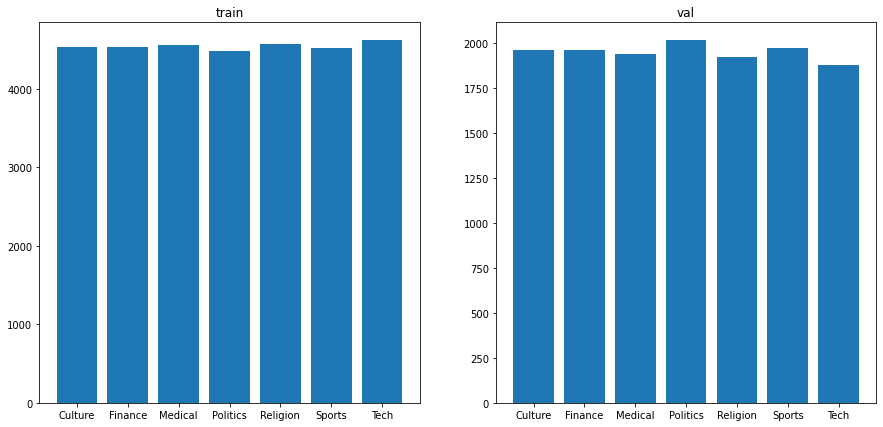

In [29]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plot_bar(y_train)
plt.title('train')
plt.subplot(1,2,2)
plot_bar(y_val)
plt.title('val')

> so our data is quite palanced in both `train` and `val`

###  Bag-of-words

In [28]:
vectorizer = CountVectorizer(binary=True)

In [57]:
train_x_vectors = vectorizer.fit_transform(X_train)

In [59]:
y_train[0:5]

['Medical', 'Finance', 'Sports', 'Politics', 'Religion']

In [14]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val= label_encoder.transform(y_val)  

In [62]:
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(train_x_vectors, y_train)

SVC(kernel='linear')

In [83]:
X_val_vectors= vectorizer.transform(X_val)

In [84]:
res = clf_svm.predict(X_val_vectors)

In [90]:
print( round(metrics.accuracy_score(y_val,res) *100  , 2) , "%")

97.52 %


### predict_function

In [107]:
def news_labels(text):
    text_vectorized = vectorizer.transform(text)
    res = clf_svm.predict(text_vectorized)
    print(labels[res[0]])

In [117]:
print("new class is : " , end = ' ')
news_labels([X_val[2]])
print("part of the news text : " , end = ' ')
print(X_val[2][0:200])

new class is :  Sports
part of the news text :  تتجه أنظار الملايين من عشاق الساحرة المستديرة في كل أنحاء الوطن العربي صوب العاصمتين البرازيليتين، الحالية برازيليا والقديمة ريو دي جانيرو لمتابعة ضربة البداية لمسيرة كل من المنتخبين العراقي والجزائري


> the limitation of this approtch is that is there is a new word in test set the model will not be able to handel it and just give it a `0` and this word may be an altternitive in word in training and the model will still not be able to get it 
- we need more than just representing the sentence like that we need word `embedding` where words that has similary meaning are close to each other in the `vector space`

### word vectors
- `word2vec`
    - word2vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. Embeddings learned through word2vec have proven to be successful on a variety of downstream natural language processing tasks.


> i got an arabic embedding model from the internet and i will use it

In [130]:
arabic_model_path = 'D:/Bi electric scolership/NLP/arabic_model'
model_name = 'full_grams_cbow_100_twitter.mdl'
model = gensim.models.Word2Vec.load(os.path.join(arabic_model_path , model_name))

In [133]:
print("We've",len(model.wv.index_to_key),"vocabularies")

We've 1476715 vocabularies


In [134]:
model.wv.save_word2vec_format("D:/Bi electric scolership/NLP/spacyModel/aravec.txt")

In [163]:
!python -m spacy  init vectors ar "D:/Bi electric scolership/NLP/spacyModel/aravec.zip" "D:/Bi electric scolership/NLP/spacy.aravec.model" 
# returns a spaCy pipeline directory containing the vocab and vectors.

 ℹ Creating blank nlp object for language 'ar'
✔ Successfully converted 1476715 vectors
✔ Saved nlp object with vectors to output directory. You can now use the path to
it in your config as the 'vectors' setting in [initialize].
 


In [71]:
nlp = spacy.load("D:/Bi electric scolership/NLP/spacy.aravec.model")

In [16]:
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [17]:
class Preprocessor:
    def __init__(self, tokenizer, **cfg):
        self.tokenizer = tokenizer

    def __call__(self, text):
        preprocessed = clean_str(text)
        return self.tokenizer(preprocessed)

In [73]:
nlp.tokenizer = Preprocessor(nlp.tokenizer)

In [19]:
docs = [nlp(text) for text in X_train]
train_x_word_vectors = [x.vector for x in docs]

val_docs = [nlp(text) for text in X_val]
val_x_word_vectors =  [x.vector for x in val_docs]


In [176]:
print(type(docs))
print(type(docs[0]))
print(type(docs[0].vector))

<class 'list'>
<class 'spacy.tokens.doc.Doc'>
<class 'numpy.ndarray'>


> we can see that `docs` is a list and each element in it is a emdedding vector for each training example
- so we need to use `.vector` to convert them to array so we can use them in training

In [181]:
clf_svm_wv = svm.SVC(kernel='linear')
clf_svm_wv.fit(train_x_word_vectors, y_train)

SVC(kernel='linear')

In [206]:
train_x_word_vectors[0].shape

(100,)

In [186]:
res = clf_svm_wv.predict(val_x_word_vectors)

In [1]:
print( round(metrics.accuracy_score(y_val,res) *100  , 2) , "%")

97.03 %


In [200]:
def aravec_predict(text):
    test_docs = [nlp(text) for text in text]
    test_x_word_vectors =  [x.vector for x in test_docs]
    res = clf_svm_wv.predict(test_x_word_vectors)
    print(labels[res[0]])

In [30]:
sample_index = 150
print("new class is : " , end = ' ')
aravec_predict([X_val[sample_index]])
print("part of the news text : " , end = ' ')
print(X_val[sample_index][0:200])

new class is :  Medical
part of the news text :  تزامناً مع يوم العمال العالمي، الذي يحتفل به العالم في الأول من مايو من كل عام، نظم سوق الجبيل، يومي أمس  واليوم  إبريل الجاري، فحوصاً طبية مجانية للمستثمرين في السوق، والعمال، والمتسوقين، والزوار


> now there are some improvments
- first thing is that : now even if there is a word that was not in training and in val only , the model will still be able to classify it as long as this word is in our dict
- new alternative words in val and not in train will still get a good classification as long it's on our dict

> one thing about word embeddings is that :
- it will give the same embedding for the same word in different sentence even if there have different context in these diiferent sentence

### use deep learning 

> now from the pretraining embeddings i want to get to get an embeddings matrix for each word in my data

In [76]:
from keras.preprocessing.text import Tokenizer
vocab_size = 100000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [80]:
word_index = tokenizer.word_index

In [100]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [102]:
max_length = 100
padding_type='post'
truncation_type='post'

In [103]:
from keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=truncation_type)

X_test_padded = pad_sequences(X_val_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=truncation_type)

In [85]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    if i ==1: # out of vocab token
        pass
    else : 
        embedding_vector = nlp(word).vector
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector


In [93]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional , Dropout

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [117]:
from tensorflow.keras.models import Sequential
classes = len(labels)
model_v2 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(150, return_sequences=True)), 
    Bidirectional(LSTM(150)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu') , 
    Dropout(0.2),
   Dense(classes, activation='softmax')
])

In [118]:
model_v2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [119]:
model_v2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          56558800  
                                                                 
 bidirectional_6 (Bidirectio  (None, 100, 300)         301200    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 128)               38528     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [33]:
epochs = 30
history = model_v2.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_val) , batch_size = 16)

Epoch 1/30
1991/1991 [==============================] - 540s 337ms/step - loss: 1.7798 - accuracy: 0.2291 - val_loss: 1.7237 - val_accuracy: 0.3461
Epoch 2/30
1991/1991 [==============================] - 364s 225ms/step - loss: 1.7081 - accuracy: 0.2875 - val_loss: 1.5634 - val_accuracy: 0.5663
Epoch 3/30
1991/1991 [==============================] - 364s 225ms/step - loss: 1.5288 - accuracy: 0.3914 - val_loss: 1.2559 - val_accuracy: 0.6225
Epoch 4/30
1991/1991 [==============================] - 364s 225ms/step - loss: 1.3055 - accuracy: 0.4916 - val_loss: 0.9509 - val_accuracy: 0.8247
Epoch 5/30
1991/1991 [==============================] - 364s 225ms/step - loss: 1.0466 - accuracy: 0.5971 - val_loss: 0.7033 - val_accuracy: 0.8674
Epoch 6/30
1991/1991 [==============================] - 364s 225ms/step - loss: 0.8558 - accuracy: 0.6749 - val_loss: 0.5356 - val_accuracy: 0.8989
Epoch 7/30
1991/1991 [==============================] - 364s 225ms/step - loss: 0.7154 - accuracy: 0.7374 - val_

In [34]:
def LSTM_predict(text):
    test_sequences = tokenizer.texts_to_sequences(text)
    test_sequences_padded = pad_sequences(test_sequences,maxlen=max_length, padding=padding_type, 
                        truncating=truncation_type)
    probs = model_v2.predict(test_sequences_padded)
    res = np.argmax(probs)
    print(labels[res])

In [36]:
sample_index = 150
print("class is : " , end = ' ')
LSTM_predict(X_val[sample_index])
print("part of the news text : " , end = ' ')
print(X_val[sample_index][0:200])

class is :  Medical
part of the news text :  تزامناً مع يوم العمال العالمي، الذي يحتفل به العالم في الأول من مايو من كل عام، نظم سوق الجبيل، يومي أمس  واليوم  إبريل الجاري، فحوصاً طبية مجانية للمستثمرين في السوق، والعمال، والمتسوقين، والزوار


### using pretrained model

#### CAMeL-Lab/bert : 

> using `bert` to get embeddings and fine tune the model with additional layers for classification

In [1]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel , AutoModelForMaskedLM , TFAutoModel
from transformers import TFAutoModelForSequenceClassification , TFTrainer, TFTrainingArguments
from transformers import TFBertForSequenceClassification

c:\Users\hadee\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
Camel_model = TFAutoModel.from_pretrained('CAMeL-Lab/bert-base-arabic-camelbert-da')
classes = len(labels)

In [2]:
Camel_model.summary()

Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109081344 
Total params: 109,081,344
Trainable params: 109,081,344
Non-trainable params: 0
_________________________________________________________________


> Initializing empty arrays to store tokenized text.

In [39]:
seq_len = 200
num_samples = len(X_train)

Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(31850, 200)


In [4]:
for i, phrase in enumerate(X_train):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y_train))

In [6]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

train_dataset = train_dataset.map(map_func)

In [29]:
batch_size = 16
train_dataset = train_dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [30]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')


embeddings = Camel_model.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]


x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(classes, activation='softmax', name='outputs')(x)


In [28]:
Camel_model_tuned = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [2]:
Camel_model_tuned.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109081344   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         787456      bert[2][1]                 

In [27]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

Camel_model_tuned.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [18]:
history = Camel_model_tuned.fit(
    train_dataset,
    epochs=5
)

Epoch 1/5
1991/1991 [==============================] - 814s 402ms/step - loss: 0.1339 - accuracy: 0.8432
Epoch 2/5
1991/1991 [==============================] - 799s 401ms/step - loss: 0.0669 - accuracy: 0.9218
Epoch 3/5
1991/1991 [==============================] - 799s 401ms/step - loss: 0.0490 - accuracy: 0.9272
Epoch 4/5
1991/1991 [==============================] - 800s 402ms/step - loss: 0.0500 - accuracy: 0.9251
Epoch 5/5
1991/1991 [==============================] - 799s 401ms/step - loss: 0.0347 - accuracy: 0.9424


> needed  more epoches

In [ ]:
sample = X_train[0] 

In [19]:
tokens = tokenizer.encode_plus(sample, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
tokens['input_ids']

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[    2,  5365,  8311,    17, 14962, 12233,  3463,    30,  2136,
          395,    18,  2195,  1953, 12426,  1013,   378,  3615,  3532,
         5365,  8311,  5563,    30,  2259,  5482, 19524,  1912,  3680,
         6997,  2046,  3231,  8736,  1017,  3647,  4472,  5919, 15287,
          378,  2130,  4544,  1908, 14815, 12430,  5919,  1912,  4039,
         2116,   378,  2455, 17768,  2268,   378,  6973,  1069,  6922,
         7094,     9,   378,  2298,  9617, 12059,  1908,  8677,  1983,
         3808,  3421,  1912,  5457,    19, 10881,  4656,    18, 16446,
        19145,  5350, 29068,   378,  2130, 27261,  2854,  2366,     1,
         2045,  2823, 12059,  1908,  3680, 13249,  2046,   378, 14474,
         1010,  7276,  2045, 10212,     1,   378,  7627,  1955, 21370,
        14939, 11114,    18,     1, 18985, 12426,  1013,   378,  4557,
         3808,   378,  2130,  7772,  3808,  1912,  3532,  8736,  1017,
          378,  3487,  4986, 

In [26]:
def prep_data_Camel(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizer.encode_plus(text, max_length=seq_len,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return {'input_ids': tf.cast(tokens['input_ids'], tf.int32),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.int32)}


In [20]:
in_tensor = prep_data_Camel(sample)
print(in_tensor)

{'input_ids': <tf.Tensor: shape=(1, 200), dtype=int32, numpy=
 array([[    2,  5365,  8311,    17, 14962, 12233,  3463,    30,  2136,
           395,    18,  2195,  1953, 12426,  1013,   378,  3615,  3532,
          5365,  8311,  5563,    30,  2259,  5482, 19524,  1912,  3680,
          6997,  2046,  3231,  8736,  1017,  3647,  4472,  5919, 15287,
           378,  2130,  4544,  1908, 14815, 12430,  5919,  1912,  4039,
          2116,   378,  2455, 17768,  2268,   378,  6973,  1069,  6922,
          7094,     9,   378,  2298,  9617, 12059,  1908,  8677,  1983,
          3808,  3421,  1912,  5457,    19, 10881,  4656,    18, 16446,
         19145,  5350, 29068,   378,  2130, 27261,  2854,  2366,     1,
          2045,  2823, 12059,  1908,  3680, 13249,  2046,   378, 14474,
          1010,  7276,  2045, 10212,     1,   378,  7627,  1955, 21370,
         14939, 11114,    18,     1, 18985, 12426,  1013,   378,  4557,
          3808,   378,  2130,  7772,  3808,  1912,  3532,  8736,  1017,
  

> this function will return both `input_ids` and `attention_mask` that we need for predicrion

In [25]:
def Camel_predict(text):
    test_tensor = prep_data_Camel(text)
    probs = Camel_model_tuned.predict(test_tensor)
    res = np.argmax(probs)
    print(labels[res])

In [28]:
sample_index = 150
print("class is : " , end = ' ')
Camel_predict(X_val[sample_index])
print("part of the news text : " , end = ' ')
print(X_val[sample_index][0:200])

class is :  Medical
part of the news text :  تزامناً مع يوم العمال العالمي، الذي يحتفل به العالم في الأول من مايو من كل عام، نظم سوق الجبيل، يومي أمس  واليوم  إبريل الجاري، فحوصاً طبية مجانية للمستثمرين في السوق، والعمال، والمتسوقين، والزوار


### AraBert : 

In [33]:
# !pip install transformers
# !pip install farasapy
# !pip install pyarabic
# !git clone https://github.com/aub-mind/arabert

In [35]:
#from py4j.java_gateway import JavaGateway
from farasa.segmenter import FarasaSegmenter
from transformers import TFBertForSequenceClassification , AutoModel
from arabert.preprocess import ArabertPreprocessor
import arabert
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments

In [41]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_tokenizer = AutoTokenizer.from_pretrained(model_name)
# arabert_model = AutoModel.from_pretrained(model_name)  ## BertForSequenceClassification
arabert_prep = ArabertPreprocessor(model_name=model_name)
arabert_model = BertForSequenceClassification.from_pretrained(model_name)
## using automodel will give me an error because ` BertModel.forward() got an unexpected keyword argument 'labels' `  so i should use BertForSequenceClassification 
## which it's forward has labels in it


[2022-10-02 14:22:00,295 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect

In [36]:
training_data =pd.DataFrame({"text":X_train,"label":y_train})
val_data =pd.DataFrame({"text":X_val,"label":y_val})

In [37]:
classes = len(labels)
task_name = 'classification'
max_length = 200

In [ ]:
train_dataset = SingleSentenceClassificationProcessor(mode=task_name)
val_dataset = SingleSentenceClassificationProcessor(mode=task_name)

In [ ]:
train_dataset.add_examples(texts_or_text_and_labels=training_data['text'],labels=training_data['label'],overwrite_examples = True)
val_dataset.add_examples(texts_or_text_and_labels=val_data['text'],labels=val_data['label'],overwrite_examples = True)

In [38]:
train_features = train_dataset.get_features(tokenizer = arabert_tokenizer , max_length = max_length)
val_features = val_dataset.get_features(tokenizer = arabert_tokenizer , max_length = max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [40]:
print(train_features[50])

InputFeatures(input_ids=[33, 1799, 59, 127, 20, 1892, 129, 2268, 16, 797, 12, 20, 1303, 20, 1187, 12, 6, 1512, 786, 20, 427, 12, 2, 1799, 455, 1688, 23970, 4538, 1512, 127, 18967, 803, 129, 6210, 20, 797, 12, 20, 3702, 12, 20, 5213, 130, 29, 419, 2556, 12, 322, 3909, 12, 5531, 5213, 12, 6488, 6, 20, 2229, 1779, 581, 290, 20, 797, 4, 29, 3730, 20, 1045, 12, 2, 2952, 5213, 29, 290, 2829, 916, 12, 289, 1188, 12, 1799, 48, 3426, 1538, 12, 20, 1512, 20, 5213, 20, 1361, 336, 1157, 5780, 12, 290, 20, 1255, 130, 2, 527, 8318, 797, 12, 20, 1303, 289, 20, 2829, 20, 359, 12, 29, 20, 1194, 20, 3327, 12, 289, 1188, 12, 1799, 713, 20, 2241, 4, 29, 20, 1941, 20, 1445, 12, 48, 2062, 20, 1512, 20, 5213, 20, 7053, 2, 3259, 29, 2701, 12, 9153, 797, 4, 650, 12, 290, 10, 797, 12, 1147, 20, 3331, 4, 2, 20, 1430, 16, 28, 20, 547, 12, 29, 20, 9252, 12, 130, 20, 1263, 2, 727, 1263, 797, 12, 20, 1303, 290, 455, 3259, 831, 5, 5962, 2, 20, 1512, 130, 20, 7736, 322, 3823, 727, 1037, 12, 837, 12, 6, 34], attention_

In [42]:
training_args = TrainingArguments("./train")

In [46]:
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 2e-5
training_args.warmup_steps = 0
training_args.per_gpu_train_batch_size = 16
training_args.per_gpu_eval_batch_size = 16
training_args.num_train_epochs= 5
training_args.logging_steps = (len(train_features) - 1) // training_args.per_gpu_train_batch_size + 1
training_args.save_steps = training_args.logging_steps 
training_args.seed = 42

In [47]:
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer_utils.py
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)

  acc = accuracy_score(p.label_ids,preds)
  return {
      'accuracy': acc
  }

In [48]:
trainer = Trainer(model=arabert_model,
                  args = training_args,
                  train_dataset = train_features,
                  eval_dataset = val_features ,
                compute_metrics = compute_metrics
                  )

In [49]:
trainer.train()

Output exceeds the size limit. Open the full output data in a text editor
***** Running training *****
Num examples = 31850
Num Epochs = 5
Instantaneous batch size per device = 8
Total train batch size (w. parallel, distributed & accumulation) = 8
Gradient Accumulation steps = 1
Total optimization steps = 11946
INFO:transformers.trainer:***** Running Evaluation *****
INFO:transformers.trainer:  Num examples = 31850
INFO:transformers.trainer:  Batch size = 16
{"loss": 0.3570140757908424, "learning_rate": 1.6000000000000003e-05, "epoch": 1.0, "step": 90}
INFO:transformers.trainer:Saving model checkpoint to ./train/checkpoint-90
INFO:transformers.configuration_utils:Configuration saved in ./train/checkpoint-90/config.json
    accuracy                           0.92   
{"eval_loss": 0.23239801791699036 , "eval_accuracy": 0.9194444444444444, "epoch": 1.0, "step": 90}
INFO:transformers.modeling_utils:Model weights saved in ./train/checkpoint-90/pytorch_model.bin
/usr/local/lib/python3.6/dist

In [50]:
from transformers import TextClassificationPipeline
pipe = TextClassificationPipeline(model=arabert_model, tokenizer=arabert_tokenizer, return_all_scores=True)
pipe(X_train[0])

[[{'label': 'LABEL_0', 'score': 0.0036168249789625406},
  {'label': 'LABEL_1', 'score': 0.0007229067268781364},
  {'label': 'LABEL_2', 'score': 0.9777277708053589},  
  {'label': 'LABEL_3', 'score': 0.0014909171732142568},
  {'label': 'LABEL_4', 'score': 0.0009031872032210231},
  {'label': 'LABEL_5', 'score': 0.014563223347067833},
  {'label': 'LABEL_6', 'score': 0.0009752426412887871}]]


In [51]:
y_train[0]

2


In [52]:
pipe = TextClassificationPipeline(model=arabert_model, tokenizer=arabert_tokenizer, return_all_scores=False)
res = pipe(X_train[0])

In [40]:
print(res[0]['label'])
print(res[0]['label'][-1])

LABEL_2
2


In [55]:
def arabert_predict(text):
    res = pipe(text)
    int_res = int(res[0]['label'][-1]) # will return only the label
    print(labels[int_res])

In [27]:
sample_index = 150
print("class is : " , end = ' ')
arabert_predict(X_val[sample_index])
print("part of the news text : " , end = ' ')
print(X_val[sample_index][0:200])

class is :  Medical
part of the news text :  تزامناً مع يوم العمال العالمي، الذي يحتفل به العالم في الأول من مايو من كل عام، نظم سوق الجبيل، يومي أمس  واليوم  إبريل الجاري، فحوصاً طبية مجانية للمستثمرين في السوق، والعمال، والمتسوقين، والزوار


### using : BERT multilingual base model 

In [6]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
multilingual_model = TFBertModel.from_pretrained("bert-base-multilingual-cased")
text = X_train[0]
encoded_input = tokenizer(text, return_tensors='tf')
output = multilingual_model(encoded_input)

Downloading: 100%|██████████|972k/972k [00:00<00:00, 2.15MB/s]
Downloading: 100%|██████████|29.0/29.0 [00:00<00:00, 887B/s]
Downloading: 100%|██████████|625/625 [00:00<00:00, 15.8kB/s]
Downloading: 100%|██████████|1.01G/1.01G [00:41<00:00, 17.0MB/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the mode

In [7]:
multilingual_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  177853440 
Total params: 177,853,440
Trainable params: 177,853,440
Non-trainable params: 0
_________________________________________________________________


In [8]:
seq_len = 200
num_samples = len(X_train)

# initialize empty zero arrays
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

# check shape
Xids.shape

(31850, 200)


In [9]:
num_samples_val = len(X_val)

# initialize empty zero arrays
Xids_val = np.zeros((num_samples_val, seq_len))
Xmask_val = np.zeros((num_samples_val, seq_len))

# check shape
Xids_val.shape

(13650, 200)


In [10]:
for i, phrase in enumerate(X_train):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # assign tokenized outputs to respective rows in numpy arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [11]:
for i, phrase in enumerate(X_val):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # assign tokenized outputs to respective rows in numpy arrays
    Xids_val[i, :] = tokens['input_ids']
    Xmask_val[i, :] = tokens['attention_mask']

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((Xids_val, Xmask_val, y_val))

In [13]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
train_dataset = train_dataset.map(map_func)
val_dataset = val_dataset.map(map_func)

In [14]:
# we will split into batches of 16
batch_size = 16

# shuffle and batch - dropping any remaining samples that don't cleanly
# fit into a batch of 16
train_dataset = train_dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [15]:
classes = len(labels)
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')


embeddings = multilingual_model.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]


x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(classes, activation='softmax', name='outputs')(x)

In [16]:
multilingual_model_tuned = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [18]:
multilingual_model_tuned.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          multiple             177853440   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         787456      bert[3][1]                 

In [19]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

multilingual_model_tuned.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [38]:
history = multilingual_model_tuned.fit(
    train_dataset,
    epochs=5
)

Epoch 1/5
1991/1991 [==============================] - 913s 570ms/step - loss:  0.537819 - accuracy: 0.7822 
Epoch 2/5
1991/1991 [==============================] - 811s 507ms/step - loss: 0.409763  - accuracy: 0.7909
Epoch 3/5
1991/1991 [==============================] - 811s 507ms/step - loss:  0.451422 - accuracy: 0.8109
Epoch 4/5
1991/1991 [==============================] - 811s 507ms/step - loss: 0.332129 - accuracy: 0.8742 
Epoch 5/5
1991/1991 [==============================] - 811s 507ms/step - loss: 0.366856  - accuracy: 0.8804


In [22]:
def prep_data_multilingual(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizer.encode_plus(text, max_length=seq_len,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return {'input_ids': tf.cast(tokens['input_ids'], tf.int32),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.int32)}


In [23]:
sample = X_train[0] 
in_tensor = prep_data_multilingual(sample)
print(in_tensor)

{'input_ids': <tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[   101,  65961,  59901,  16498,  88359,    118,    781,  22955,
         10765,    781,  37423,  67596,    131,  28598,    771,    119,
         14610,  15764,  59901,  50643,  20556,  10461,    752,  93800,
         21251,  65961,  59901,  16498,  88359,  85549,    131,  26351,
         16404,  59901, 107559,  62765,  10210,  71403,    761,  37548,
         13154,  24979,  59901,  49170,  10673,    787,  34418,  54422,
         10535, 106487,  20250,  10535,    752,  13121,  72197,  10289,
           759,  43348,  59901,  24639,  40446,  11509, 106487,  10210,
         59901, 111171,  93864,    752,  13623,    763,  25050,  10502,
         12616,  11437,    752,  10723,  17652,  10502,  11417,    110,
           752,  19137,  59901,  34783,  28241,  11693,  59901,  10765,
         20132,  12611,  10289,    766,  56363,  14472,  23411,  57150,
         10210,  23485,    120,  14500,  21679,  59901,  10700,  44528,
  

In [24]:
def multilingual_predict(text):
    test_tensor = prep_data_multilingual(text)
    probs = multilingual_model_tuned.predict(test_tensor)
    res = np.argmax(probs)
    print(labels[res])

In [26]:
sample_index = 150
print("class is : " , end = ' ')
multilingual_predict(X_val[sample_index])
print("part of the news text : " , end = ' ')
print(X_val[sample_index][0:200])

class is :  Medical
part of the news text :  تزامناً مع يوم العمال العالمي، الذي يحتفل به العالم في الأول من مايو من كل عام، نظم سوق الجبيل، يومي أمس  واليوم  إبريل الجاري، فحوصاً طبية مجانية للمستثمرين في السوق، والعمال، والمتسوقين، والزوار


 | Model                                | Epochs | Time  | train_Acc |
  | ------------------------------------ | ------ | ------ | ----- |
  | bag_of_words             | _  | 3 min  | 97.52%    |
  | aravec            | _ | 4 min  | 97.03%   |
  | LSTM        | 30 epochs  | 3h  | 95.4%   |
  | CaMel       | 5 epochs | 1.2h  | 94%   |
  | AraBert       | 5 epochs  | 2h | 92%   |
  | BERT_Multilingual      | 5 epochs  | 1.5h | 88%   | |



> `BERT` models can get us better results with more training 